# Analysis of DrugBank Data
**Author:** Bartosz Czechowski (bc458939)  
**Contact:** b.czechowski@student.uw.edu.pl  
**Context:** Created as part of the Python Programming Course at MIMUW (2024/25 Winter Semester)

## Prerequisites

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import os

FILE_NAME = os.path.join('data', 'drugbank_partial.xml')

# namespace
ns = {
    "db": "http://www.drugbank.ca", 
}

# Does not parse nested field correctly (e.g. groups)
df = pd.read_xml(
    FILE_NAME,  # Replace with your XML file path
)
df

,type,created,updated,drugbank-id,name,description,cas-number,unii,state,groups,...,snp-adverse-drug-reactions,targets,enzymes,carriers,transporters,fda-label,msds,average-mass,monoisotopic-mass,calculated-properties
0,biotech,2005-06-13,2024-01-02,BIOD00024,Lepirudin,Lepirudin is a recombinant hirudin formed by 6...,138068-37-8,Y43GF64R34,solid,\n,...,None,\n,None,None,None,None,None,NaN,NaN,None
1,biotech,2005-06-13,2024-01-02,BIOD00071,Cetuximab,Cetuximab is a recombinant chimeric human/mous...,205923-56-4,PQX0D8J21J,liquid,\n,...,None,\n,None,None,None,//s3-us-west-2.amazonaws.com/drugbank/fda_labe...,//s3-us-west-2.amazonaws.com/drugbank/msds/DB0...,NaN,NaN,None
2,biotech,2005-06-13,2024-03-13,BIOD00001,Dornase alfa,Dornase alfa is a biosynthetic form of human d...,143831-71-4,953A26OA1Y,liquid,\n,...,None,\n,None,None,None,//s3-us-west-2.amazonaws.com/drugbank/fda_labe...,//s3-us-west-2.amazonaws.com/drugbank/msds/DB0...,NaN,NaN,None
3,biotech,2005-06-13,2024-01-02,BIOD00084,Denileukin diftitox,A recombinant DNA-derived cytotoxic protein co...,173146-27-5,25E79B5CTM,liquid,\n,...,None,\n,None,None,None,//s3-us-west-2.amazonaws.com/drugbank/fda_labe...,None,NaN,NaN,None
4,biotech,2005-06-13,2024-02-02,BIOD00052,Etanercept,Dimeric fusion protein consisting of the extra...,185243-69-0,OP401G7OJC,liquid,\n,...,None,\n,None,None,None,None,None,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,biotech,2005-06-13,2024-03-13,BIOD00088,Octreotide,Acromegaly is a disorder caused by excess grow...,83150-76-9,RWM8CCW8GP,solid,\n,...,None,\n,\n,\n,\n,//s3-us-west-2.amazonaws.com/drugbank/fda_labe...,None,NaN,NaN,None
96,biotech,2005-06-13,2024-03-13,DB05600,Interferon alfa-2b,Interferon alpha 2b (human leukocyte clone hif...,98530-12-2,43K1W2T1M6,liquid,\n,...,None,\n,\n,None,None,//s3-us-west-2.amazonaws.com/drugbank/fda_labe...,None,NaN,NaN,None
97,small molecule,2005-06-13,2024-01-02,BIOD00051,Abarelix,Synthetic decapeptide antagonist to gonadotrop...,183552-38-7,W486SJ5824,solid,\n,...,None,\n,None,None,None,//s3-us-west-2.amazonaws.com/drugbank/fda_labe...,None,1416.09,1414.684072,\n
98,biotech,2005-06-13,2024-03-13,BIOD00016,Oxytocin,Sir Henry H. Dale first identified oxytocin an...,50-56-6,1JQS135EYN,liquid,\n,...,None,\n,\n,\n,\n,None,None,NaN,NaN,None


In [4]:
import xml.etree.ElementTree as ET

# Parse XML file
et_tree = ET.parse(FILE_NAME)
et_root = et_tree.getroot()

def text_or_none(element):
    return element.text if element is not None else None

# We treat name as the primary key because it is unique and since one drug has multiple ids its problematic
def extract_nested(nested_path, column_name='nested'):
    nested_data = []
    for drug in et_root.findall("db:drug", ns):
        id = text_or_none(drug.find("db:drugbank-id[@primary='true']", ns))
        if id is None:
            continue
        name = text_or_none(drug.find("db:name", ns))
        if name is None:
            continue
        current_el = [
            text_or_none(e) for e in drug.findall(nested_path, ns)
        ]
        nested_data.append({
            "name": name,
            column_name: current_el,
        })
    
    return pd.DataFrame(nested_data)


## 1. Drug Information DataFrame

In [5]:
# all the simple fields
drug_info_df = df[['drugbank-id', 'name', 'type', 'description', 'state', 'indication',
                   'mechanism-of-action']]
# and the nested food interactions
food_interactions_df = extract_nested("db:food-interactions/db:food-interaction", 'food-interactions')

# merge the two dataframes
drug_info_df = pd.merge(drug_info_df, food_interactions_df, on='name', how='inner')
drug_info_df

# NOTE : we choose an arbitrary drugbank-id since it was not specified in the tast

,drugbank-id,name,type,description,state,indication,mechanism-of-action,food-interactions
0,BIOD00024,Lepirudin,biotech,Lepirudin is a recombinant hirudin formed by 6...,solid,Lepirudin is indicated for anticoagulation in ...,Lepirudin is a direct thrombin inhibitor used ...,[Avoid herbs and supplements with anticoagulan...
1,BIOD00071,Cetuximab,biotech,Cetuximab is a recombinant chimeric human/mous...,liquid,Cetuximab indicated for the treatment of local...,The epidermal growth factor receptor (EGFR) is...,[]
2,BIOD00001,Dornase alfa,biotech,Dornase alfa is a biosynthetic form of human d...,liquid,Used as adjunct therapy in the treatment of cy...,Dornase alfa is a biosynthetic form of human D...,[]
3,BIOD00084,Denileukin diftitox,biotech,A recombinant DNA-derived cytotoxic protein co...,liquid,For treatment of cutaneous T-cell lymphoma,Denileukin diftitox binds to the high-affinity...,[]
4,BIOD00052,Etanercept,biotech,Dimeric fusion protein consisting of the extra...,liquid,Etanercept is indicated for the treatment of m...,There are two distinct receptors for TNF (TNFR...,[]
...,...,...,...,...,...,...,...,...
95,BIOD00088,Octreotide,biotech,Acromegaly is a disorder caused by excess grow...,solid,Octreotide by injection is used for the treatm...,Octreotide binds to somatostatin receptors cou...,[Take on an empty stomach. The oral capsules s...
96,DB05600,Interferon alfa-2b,biotech,Interferon alpha 2b (human leukocyte clone hif...,liquid,"For the treatment of hairy cell leukemia, mali...",Interferon alpha binds to type I interferon re...,[Avoid alcohol.]
97,BIOD00051,Abarelix,small molecule,Synthetic decapeptide antagonist to gonadotrop...,solid,For palliative treatment of advanced prostate ...,Abarelix binds to the gonadotropin releasing h...,[]
98,BIOD00016,Oxytocin,biotech,Sir Henry H. Dale first identified oxytocin an...,liquid,Administration of exogenous oxytocin is indica...,Oxytocin plays a vital role in labour and deli...,[]


## 2. Synonyms dataframe and graph

In [6]:
# First create a dataframe mapping a drugbank-id to a name since names are easier to work with

def id_name():
    data = dict()
    for drug in et_root.findall("db:drug", ns):
        ids = drug.findall("db:drugbank-id", ns)
        if len(ids) == 0:
            continue
        ids = [id.text for id in ids]
        name = drug.find("db:name", ns).text
        for id in ids:
            data[id] = name

    dfdict = {"id": [], "name": []}
    for k, v in data.items():
        dfdict["id"].append(k)
        dfdict["name"].append(v)
         
    return pd.DataFrame(dfdict)

id_name_df = id_name()
id_name_df

,id,name
0,DB00001,Lepirudin
1,BTD00024,Lepirudin
2,BIOD00024,Lepirudin
3,DB00002,Cetuximab
4,BTD00071,Cetuximab
...,...,...
332,BTD00016,Oxytocin
333,BIOD00016,Oxytocin
334,DB00108,Natalizumab
335,BTD00083,Natalizumab


In [7]:
# then connect id to synonyms list
id_to_synonyms_df = extract_nested("db:synonyms/db:synonym", 'synonyms')
id_to_synonyms_df = pd.merge(id_name_df, id_to_synonyms_df, on='name', how='inner')
id_to_synonyms_df

,id,name,synonyms
0,DB00001,Lepirudin,"[[Leu1, Thr2]-63-desulfohirudin, Desulfatohiru..."
1,BTD00024,Lepirudin,"[[Leu1, Thr2]-63-desulfohirudin, Desulfatohiru..."
2,BIOD00024,Lepirudin,"[[Leu1, Thr2]-63-desulfohirudin, Desulfatohiru..."
3,DB00002,Cetuximab,"[Cetuximab, Cétuximab, Cetuximabum]"
4,BTD00071,Cetuximab,"[Cetuximab, Cétuximab, Cetuximabum]"
...,...,...,...
332,BTD00016,Oxytocin,"[Oxitocina, Oxytocin]"
333,BIOD00016,Oxytocin,"[Oxitocina, Oxytocin]"
334,DB00108,Natalizumab,"[Anti-alpha4 integrin, Anti-VLA4, IMMUNOGLOBUL..."
335,BTD00083,Natalizumab,"[Anti-alpha4 integrin, Anti-VLA4, IMMUNOGLOBUL..."


In [8]:
import networkx as nx

def print_synonyms(drug_id, fixed_seed = None):
    row = id_to_synonyms_df[id_to_synonyms_df["id"] == drug_id]
    if row.empty:
        print(f"Drug with id {drug_id} not found")
        return
    name = row["name"].iloc[0]
    synonyms = row["synonyms"].iloc[0]
    synonyms = [syn for syn in synonyms if syn != name]

    G = nx.Graph()
    nx.add_star(G, [name] + synonyms)

    node_colors = ['red' if node == name else 'blue' for node in G.nodes()]
    
    pos = nx.spring_layout(G, seed=fixed_seed)
    
    # Draw the graph without labels
    nx.draw(
        G,
        pos,
        with_labels=False,  # Turn off the default labels
        node_color=node_colors,
        node_size=1000,  # Node size
        edge_color="gray",
    )
    
    # Draw labels as nodes
    for node, (x, y) in pos.items():
        plt.scatter(x, y, s=1000, color='white', edgecolor='black', zorder=3)
        plt.text(
            x, y,
            node,
            fontsize=10,
            ha='center',
            va='center',
            bbox=dict(facecolor='white', alpha=0.9, edgecolor='black', boxstyle='round,pad=0.3')
        )
    
    plt.title("Synonyms Graph", fontsize=14)
    plt.axis('off')  # Hide axes
    plt.show()

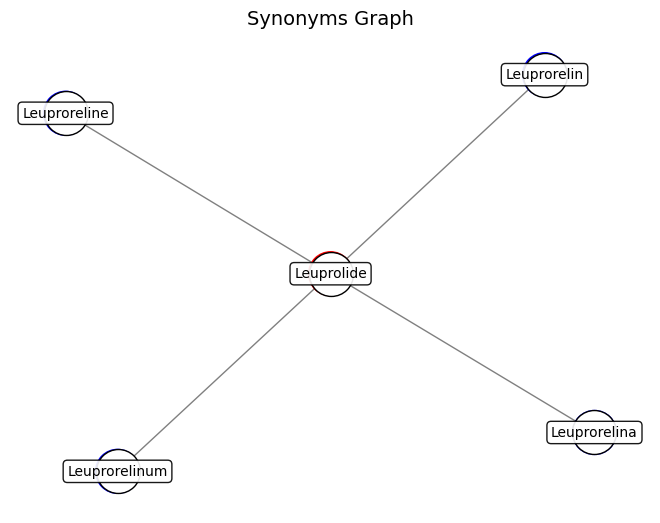

In [9]:
DRUG_ID = "DB00007"
print_synonyms(DRUG_ID)

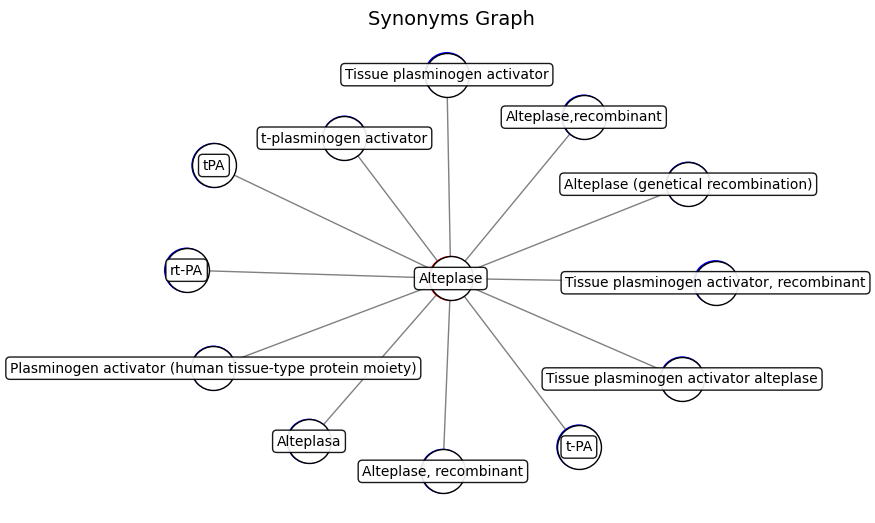

In [10]:
DRUG_ID = "DB00009"
# for large graphs some seeds can make long names overlap,
# so we fix (and possibly tweak) the seed to reduce the chance of that happening
print_synonyms(DRUG_ID, 420) 

## 3. Pharmaceutical products

In [11]:
# somewhat similar to extract_nested but not worth refactoring
def extract_nested_product():
    nested_data = []
    for drug in et_root.findall("db:drug", ns):
        id = text_or_none(drug.find("db:drugbank-id[@primary='true']", ns))
        if id is None:
            continue
        name = text_or_none(drug.find("db:name", ns))
        if name is None:
            continue
        
        
        for product in drug.findall('db:products/db:product', ns):
            product_name = text_or_none(product.find('db:name', ns))
            labeller = text_or_none(product.find('db:labeller', ns))
            # for non-us drugs this will be empty
            ndc_product_code = text_or_none(product.find('db:ndc-product-code', ns))
            dosage_form = text_or_none(product.find('db:dosage-form', ns))
            route = text_or_none(product.find('db:route', ns))
            # im not sure if strength is what is asked for but it's the best fit
            strength = text_or_none(product.find('db:strength', ns))
            country = text_or_none(product.find('db:country', ns))
            source = text_or_none(product.find('db:source', ns))

            nested_data.append({
                "id": id,
                "product_name": product_name,
                "labeller": labeller,
                "ndc_product_code": ndc_product_code,
                "dosage_form": dosage_form,
                "route": route,
                "strength": strength,
                "country": country,
                "source": source,
            })
            
    return pd.DataFrame(nested_data)

product_df = extract_nested_product()
product_df

,id,product_name,labeller,ndc_product_code,dosage_form,route,strength,country,source
0,DB00001,Refludan,Bayer,50419-150,Powder,Intravenous,50 mg/1mL,US,FDA NDC
1,DB00001,Refludan,Bayer,None,"Powder, for solution",Intravenous,50 mg / vial,Canada,DPD
2,DB00001,Refludan,Celgene Europe Limited,None,"Injection, solution, concentrate",Intravenous,50 mg,EU,EMA
3,DB00001,Refludan,Celgene Europe Limited,None,"Injection, solution, concentrate",Intravenous,50 mg,EU,EMA
4,DB00001,Refludan,Celgene Europe Limited,None,"Injection, solution, concentrate",Intravenous,20 mg,EU,EMA
...,...,...,...,...,...,...,...,...,...
4579,DB00108,Tysabri,Elan Pharmaceuticals,59075-730,Injection,Intravenous,300 mg/15mL,US,FDA NDC
4580,DB00108,Tysabri,Biogen Inc.,64406-008,Injection,Intravenous,300 mg/15mL,US,FDA NDC
4581,DB00108,Tysabri,Biogen,None,Solution,Intravenous,300 mg / 15 mL,Canada,DPD
4582,DB00108,Tysabri,Biogen Netherlands B.V.,None,"Injection, solution, concentrate",Intravenous,300 mg,EU,EMA


In [12]:
df.columns

Index(['type', 'created', 'updated', 'drugbank-id', 'name', 'description',
       'cas-number', 'unii', 'state', 'groups', 'general-references',
       'synthesis-reference', 'indication', 'pharmacodynamics',
       'mechanism-of-action', 'toxicity', 'metabolism', 'absorption',
       'half-life', 'protein-binding', 'route-of-elimination',
       'volume-of-distribution', 'clearance', 'classification', 'salts',
       'synonyms', 'products', 'international-brands', 'mixtures', 'packagers',
       'manufacturers', 'prices', 'categories', 'affected-organisms',
       'dosages', 'atc-codes', 'ahfs-codes', 'pdb-entries', 'patents',
       'food-interactions', 'drug-interactions', 'sequences',
       'experimental-properties', 'external-identifiers', 'external-links',
       'pathways', 'reactions', 'snp-effects', 'snp-adverse-drug-reactions',
       'targets', 'enzymes', 'carriers', 'transporters', 'fda-label', 'msds',
       'average-mass', 'monoisotopic-mass', 'calculated-properties'],
 

## 4. Number of pathways

In [25]:
def extract_pathway_data():
    nested_data = []
    for drug in et_root.findall("db:drug", ns):
        id = text_or_none(drug.find("db:drugbank-id[@primary='true']", ns))
        if id is None:
            continue
        name = text_or_none(drug.find("db:name", ns))
        if name is None:
            continue
        
        
        for pathway in drug.findall('db:pathways/db:pathway', ns):
            pathway_name = text_or_none(pathway.find('db:name', ns))

            drugs = [
                text_or_none(drug) for drug in pathway.findall('db:drugs/db:drug/db:name', ns)
            ]

            nested_data.append({
                "pathway-name": pathway_name,
                "drugs": drugs,
            })

    return pd.DataFrame(nested_data)

In [29]:
# we'll reuse the function
pathway_df = extract_pathway_data()
# answer to the question:
pathway_df["pathway-name"].nunique()

12

## 5. Pathway and drugs interacting with it graph

In [32]:
# the previous df already answers this question
pathway_df

,pathway-name,drugs
0,Lepirudin Action Pathway,"[Lepirudin, Phylloquinone, Calcium]"
1,Cetuximab Action Pathway,[Cetuximab]
2,Bivalirudin Action Pathway,"[Bivalirudin, Phylloquinone, Calcium]"
3,Alteplase Action Pathway,"[Alteplase, Phylloquinone, Calcium]"
4,Urokinase Action Pathway,"[Urokinase, Phylloquinone, Calcium]"
5,Reteplase Action Pathway,"[Reteplase, Phylloquinone, Calcium]"
6,Anistreplase Action Pathway,"[Anistreplase, Phylloquinone, Calcium]"
7,Tenecteplase Action Pathway,"[Tenecteplase, Phylloquinone, Calcium]"
8,Abciximab Action Pathway,[Abciximab]
9,Eptifibatide Action Pathway,[Eptifibatide]


In [34]:
# but the exploded version is more useful
pathway_exploded_df = pathway_df.explode('drugs')
pathway_exploded_df.head()

,pathway-name,drugs
0,Lepirudin Action Pathway,Lepirudin
0,Lepirudin Action Pathway,Phylloquinone
0,Lepirudin Action Pathway,Calcium
1,Cetuximab Action Pathway,Cetuximab
2,Bivalirudin Action Pathway,Bivalirudin


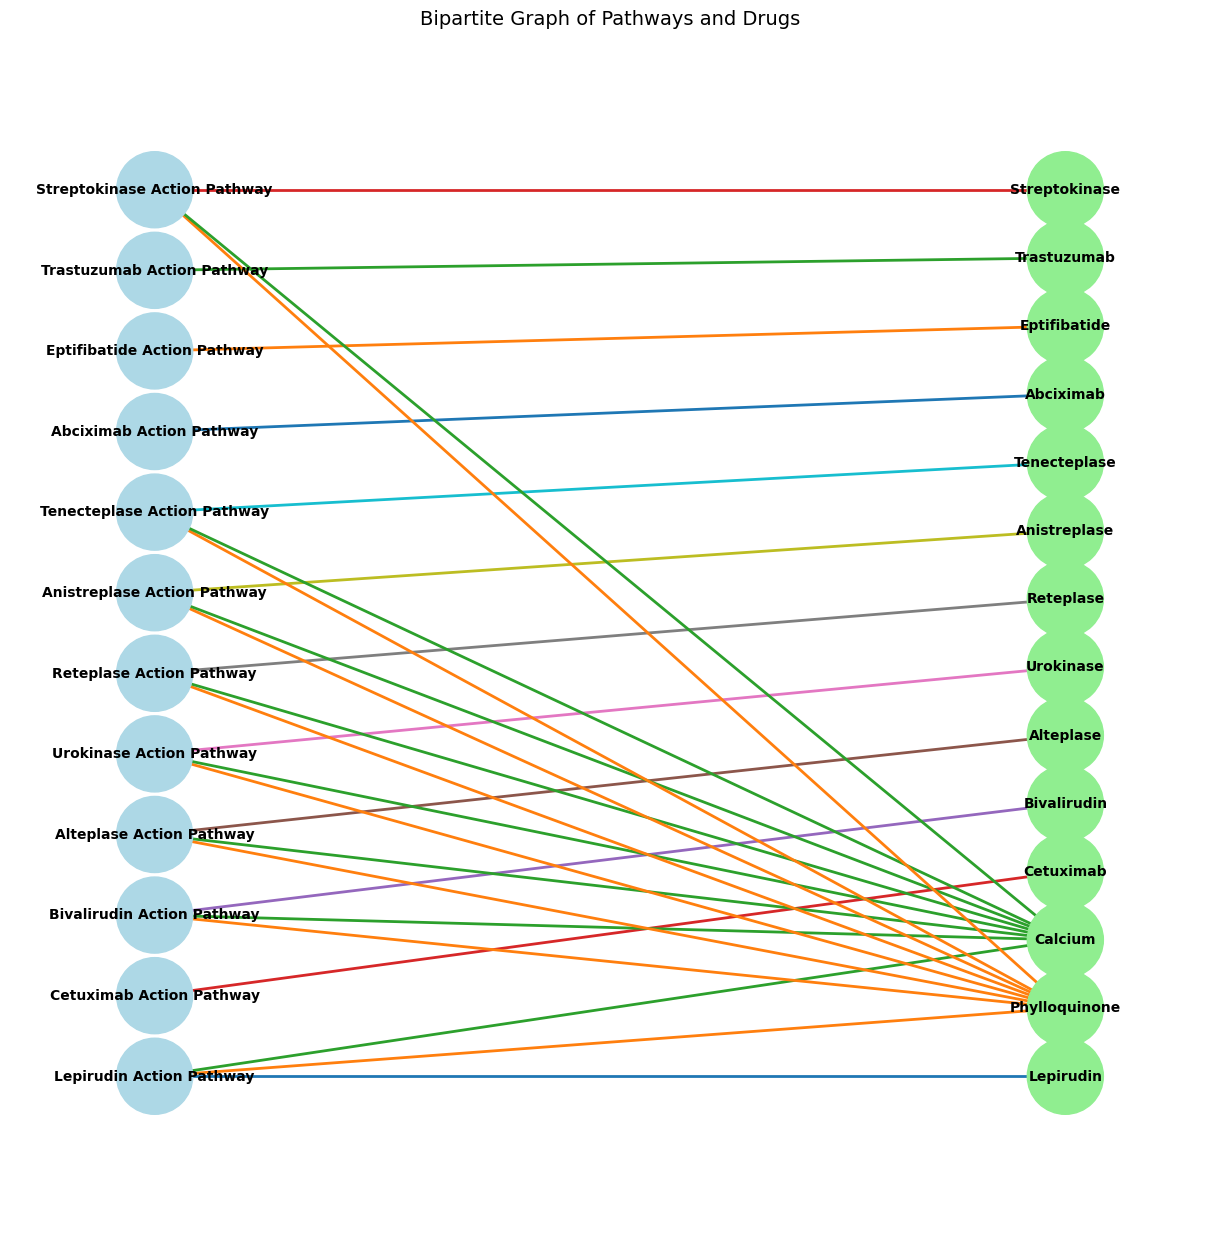

In [62]:
import networkx as nx
from textwrap import shorten

G = nx.Graph()

# nodes
pathways = pathway_exploded_df["pathway-name"].unique()
drugs = pathway_exploded_df["drugs"].unique()
G.add_nodes_from(pathways, bipartite=0)
G.add_nodes_from(drugs, bipartite=1)

# edges
edges = list(pathway_exploded_df.itertuples(index=False, name=None))
G.add_edges_from(edges)

# Generate a color map for the pathways, alternatively could be a
drug_no = len(drugs)
drug_colors = {drug: f"C{i % drug_no}" for i, drug in enumerate(drugs)}
edge_colors = [drug_colors[edge[1]] for edge in G.edges()]

# drawing
plt.figure(figsize=(12, 12))
pos = nx.bipartite_layout(G, pathways)
# if a really long name were to be cut off, it would be replaced with "..."
node_labels = {node: shorten(node, width=15, placeholder="...") for node in G.nodes()}
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=3000,
    node_color=["lightblue" if n in pathways else "lightgreen" for n in G.nodes()],
    font_size=10,
    font_weight="bold",
    edge_color=edge_colors,
    width=2,
)

# to prevent cutting off the labels
x_limits = plt.xlim()
y_limits = plt.ylim()
plt.xlim(x_limits[0] - 0.1, x_limits[1] + 0.1)
plt.ylim(y_limits[0] - 0.1, y_limits[1] + 0.1)

plt.title("Bipartite Graph of Pathways and Drugs", fontsize=14)
plt.show()


## 6. Number of pathways interacted with for each drug

In [79]:
# if we're only interesting in the drugs described in the reduced dataset
drug_path_counts = pathway_exploded_df["drugs"].value_counts()
drug_path_df = df[['name']].copy()
drug_path_df['pathway_count'] = drug_path_df['name'].map(lambda x: drug_path_counts.get(x, 0))
drug_path_df = drug_path_df.sort_values('pathway_count', ascending=False)
drug_path_df

,name,pathway_count
0,Lepirudin,1
1,Cetuximab,1
8,Alteplase,1
5,Bivalirudin,1
29,Tenecteplase,1
...,...,...
95,Octreotide,0
96,Interferon alfa-2b,0
97,Abarelix,0
98,Oxytocin,0


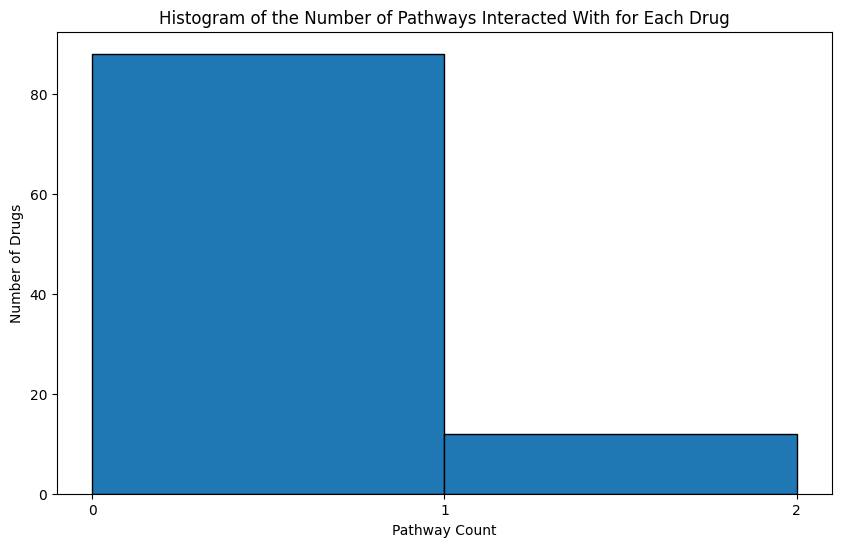

In [94]:
def plot_path_histogram(pth_df, col_name='pathway_count'):
    plt.figure(figsize=(10, 6))

    max_count = pth_df[col_name].max()
    hist_bins = range(0, max_count + 2)

    # Plot histogram with custom bins
    pth_df[col_name].hist(bins=hist_bins, edgecolor='black')

    # Set the x-ticks to match the bin edges
    plt.xticks(hist_bins)

    # Update the x-label
    plt.xlabel('Pathway Count')

    plt.ylabel('Number of Drugs')
    plt.title('Histogram of the Number of Pathways Interacted With for Each Drug')
    plt.grid(False)
    plt.show()

plot_path_histogram(drug_path_df)

In [93]:
# let's add the drugs not in our DB
drug_path_expanded_df = drug_path_df.copy()
new_drugs = drug_path_counts[~drug_path_counts.index.isin(df['name'])]
if not new_drugs.empty:
    print("Drugs not in the reduced dataset:")
    print(new_drugs.index)
    new_rows = pd.DataFrame({
        "name": new_drugs.index,
        "pathway_count": new_drugs.values
    })
    drug_path_expanded_df = pd.concat([drug_path_expanded_df, new_rows], ignore_index=True)

drug_path_expanded_df.sort_values('pathway_count', ascending=False)

Drugs not in the reduced dataset:
Index(['Phylloquinone', 'Calcium'], dtype='object', name='drugs')


,name,pathway_count
100,Phylloquinone,8
101,Calcium,8
2,Alteplase,1
3,Bivalirudin,1
0,Lepirudin,1
...,...,...
95,Octreotide,0
97,Abarelix,0
96,Interferon alfa-2b,0
99,Natalizumab,0


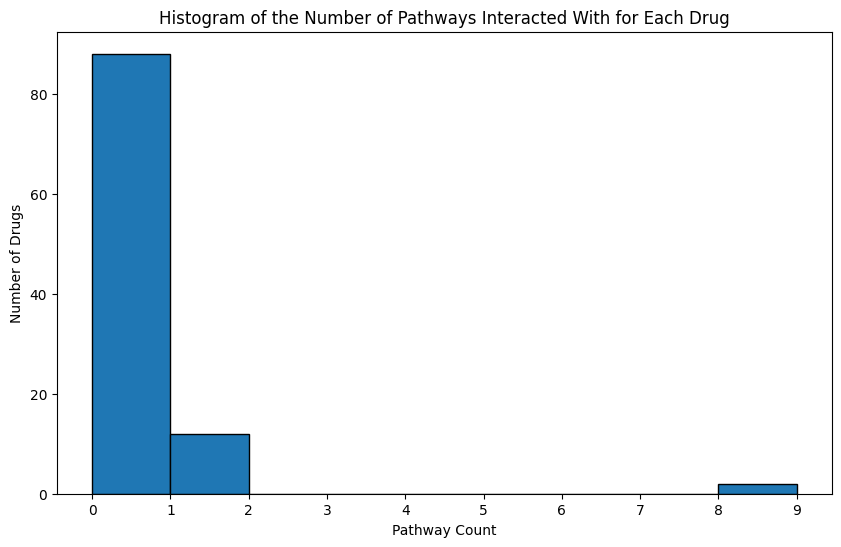

In [96]:
# let's reuse the previous function
plot_path_histogram(drug_path_expanded_df)

## 7. Protein interactions (targets)

In [15]:
import re

def extract_protein_data():
    nested_data = []
    for drug in et_root.findall("db:drug", ns):
        id = text_or_none(drug.find("db:drugbank-id[@primary='true']", ns))
        if id is None:
            continue
        name = text_or_none(drug.find("db:name", ns))
        if name is None:
            continue
        
        
        for target in drug.findall('db:targets/db:target', ns):
            target_id = text_or_none(target.find('db:id', ns))
            target_name = text_or_none(target.find('db:name', ns))

            polypeptide = target.find('db:polypeptide', ns)
            if polypeptide is None:
                continue
            # attributes used to extract from tag of form
            # <polypeptide id="P00734" source="Swiss-Prot" />
            polypeptide_id = polypeptide.attrib['id'] # assume this is the external id
            polypeptide_source = polypeptide.attrib['source']

            polypeptide_name = text_or_none(polypeptide.find('db:name', ns))
            polypeptide_gene = text_or_none(polypeptide.find('db:gene-name', ns))

            # genatlas id is actually used as the polypepide_gene field in our db
            # but we'll extract it since it's a separate field
            polypeptide_genatlas_id = None
            for ext_id in polypeptide.findall('db:external-identifiers/db:external-identifier', ns):
                if ext_id.find('db:resource', ns).text == "GenAtlas":
                    polypeptide_genatlas_id = ext_id.find('db:identifier', ns).text

            # locus is made of chromosome number and some more information
            polypeptide_locus = text_or_none(polypeptide.find('db:locus', ns))
            # getting the chromosome number is actually a little more complicated but this mostly works
            # e.g. there locus can be of form "Xp22.32 and Yp11.3"
            polypeptide_chromosome = None
            if polypeptide_locus is not None and re.match(r'(\d+)', polypeptide_locus) is not None:
                polypeptide_chromosome = re.match(r'(\d+)', polypeptide_locus).group(1)
            #polypeptide_chromosome = re.match(r'(\d+)', polypeptide_locus).group(1) if polypeptide_locus is not None else None
            polypeptide_location = text_or_none(polypeptide.find('db:cellular-location', ns))
            nested_data.append({
                "drug-name": name,
                "target-id": target_id,
                "source": polypeptide_source,
                "polypeptide-id": polypeptide_id,
                "polypeptide-name": polypeptide_name,
                "gene-name": polypeptide_gene,
                "genatlas-id": polypeptide_genatlas_id,
                "locus" : polypeptide_locus,
                "chromosome": polypeptide_chromosome,
                "location": polypeptide_location,
            })

    return pd.DataFrame(nested_data)

proteins_df = extract_protein_data()
proteins_df

,drug-name,target-id,source,polypeptide-id,polypeptide-name,gene-name,genatlas-id,locus,chromosome,location
0,Lepirudin,BE0000048,Swiss-Prot,P00734,Prothrombin,F2,F2,11p11-q12,11,Secreted
1,Cetuximab,BE0000767,Swiss-Prot,P00533,Epidermal growth factor receptor,EGFR,EGFR,7p12,7,Cell membrane
2,Cetuximab,BE0000901,Swiss-Prot,O75015,Low affinity immunoglobulin gamma Fc region re...,FCGR3B,FCGR3B,1q23,1,Cell membrane
3,Cetuximab,BE0002094,Swiss-Prot,P02745,Complement C1q subcomponent subunit A,C1QA,C1QA,1p36.12,1,Secreted
4,Cetuximab,BE0002095,Swiss-Prot,P02746,Complement C1q subcomponent subunit B,C1QB,C1QB,1p36.12,1,Secreted
...,...,...,...,...,...,...,...,...,...,...
244,Oxytocin,BE0000844,Swiss-Prot,P30559,Oxytocin receptor,OXTR,OXTR,3p25,3,Cell membrane
245,Natalizumab,BE0000590,Swiss-Prot,P13612,Integrin alpha-4,ITGA4,ITGA4,2q31.3,2,Membrane
246,Natalizumab,BE0000901,Swiss-Prot,O75015,Low affinity immunoglobulin gamma Fc region re...,FCGR3B,FCGR3B,1q23,1,Cell membrane
247,Natalizumab,BE0000710,Swiss-Prot,P12314,High affinity immunoglobulin gamma Fc receptor I,FCGR1A,FCGR1A,1q21.2-q21.3,1,Cell membrane


## 8. Pie chart of target cellular locations

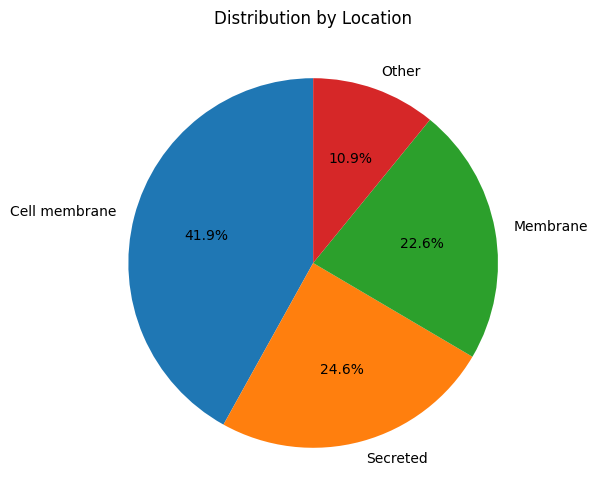

In [16]:
# we'll use the previous dataframe
location_counts = proteins_df['location'].value_counts()

def filter_small_categories(series, threshold=0.1, other_field='Other'):
    total = series.sum()
    filtered = series[series / total >= threshold]
    other_count = series[series / total < threshold].sum()
    filtered[other_field] = other_count
    return filtered

filtered_counts = filter_small_categories(location_counts)

plt.figure(figsize=(6, 6))
filtered_counts.plot.pie(
    autopct='%1.1f%%',  # Display percentages
    startangle=90,      # Rotate to start at the top
    colors=plt.cm.tab10.colors  # Use a predefined color map
)

# Add chart title and remove y-axis label
plt.title('Distribution by Location')
plt.ylabel('')  # Removes the default y-label
plt.show()

## 9. Drug groups dataframe and pie chart

In [17]:
# the function written earlier proves useful!
drug_groups_df = extract_nested("db:groups/db:group", 'groups')
drug_groups_exploded_df = drug_groups_df.explode('groups')
drug_groups_exploded_df

,name,groups
0,Lepirudin,approved
0,Lepirudin,withdrawn
1,Cetuximab,approved
2,Dornase alfa,approved
3,Denileukin diftitox,approved
...,...,...
97,Abarelix,withdrawn
98,Oxytocin,approved
98,Oxytocin,vet_approved
99,Natalizumab,approved


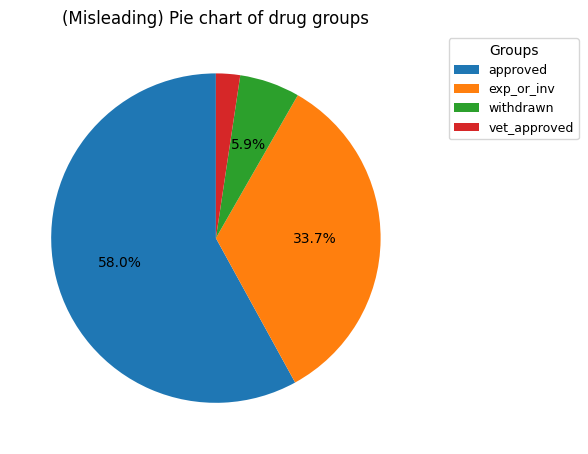

In [18]:
# We'll treat experimental and investigational as the same group (as per the task)
exploded_counts = drug_groups_exploded_df['groups'].value_counts()
exploded_counts_adj = exploded_counts.copy()
exploded_counts_adj["exp_or_inv"] = exploded_counts_adj["experimental"] + exploded_counts_adj["investigational"]
exploded_counts_adj.drop(["experimental", "investigational"], inplace=True)
exploded_counts_adj = exploded_counts_adj.sort_values(ascending=False)


total = exploded_counts.sum()

threshold = 5 # set a threshold for displaying percentages

# Use Matplotlib's `plt.pie()` directly
plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(
    exploded_counts_adj,
    autopct=lambda p: f'{p:.1f}%' if p >= threshold else '',  # Label slices above the threshold
    startangle=90,         # Rotate to start at the top
    colors=plt.cm.tab10.colors,  # Use a predefined color map
    textprops={'fontsize': 10},  # Set font size for labels
)

# Add a legend for all groups
plt.legend(
    wedges,
    exploded_counts_adj.index,
    title="Groups",
    bbox_to_anchor=(1.05, 1),  # Position legend outside the chart
    loc='upper left',
    fontsize=9,
)
plt.title("(Misleading) Pie chart of drug groups")
plt.tight_layout()  # Adjust layout to make space for the legend
plt.show()


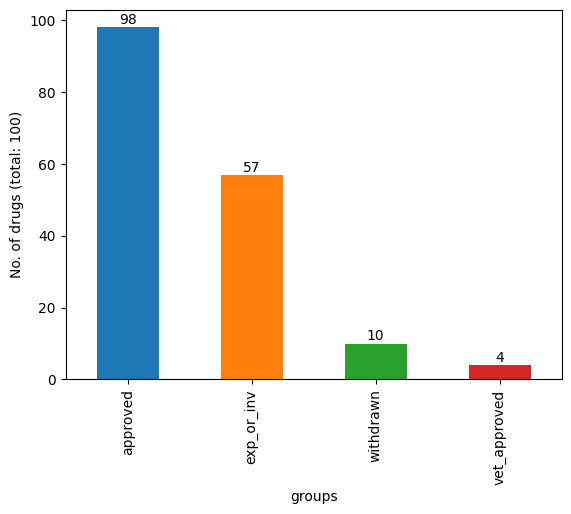

In [19]:
# I find the above misleading since the groups have major overlaps, so a pie chart is not the best choice
# therefore I'll use a bar chart instead
ax = exploded_counts_adj.plot(
    kind='bar',
    color=plt.cm.tab10.colors,
    ylabel=f'No. of drugs (total: {drug_groups_df.shape[0]})',
)

# Add the exact numbers on top of the bars
for p in ax.patches:
    height = p.get_height()  # Get the height of each bar
    ax.text(
        p.get_x() + p.get_width() / 2,  # X position of the text (center of the bar)
        height + 0.1,  # Y position of the text (a bit above the bar)
        f'{height:.0f}',  # Format the height as a number
        ha='center',  # Horizontal alignment of the text
        va='bottom',  # Vertical alignment of the text
        fontsize=10,  # Font size
    )

# Show the plot
plt.show()

In [20]:
# and the number of approved drugs that are not withdrawn
approved_drugs = drug_groups_df[drug_groups_df['groups'].apply(lambda x: 'approved' in x)]
approved_and_not_withdrawn = approved_drugs[~approved_drugs['groups'].apply(lambda x: 'withdrawn' in x)]
approved_and_not_withdrawn.shape[0]

89

## 10. Target interaction dataframe

In [21]:
# easy option is to reuse the function from earlier
# the data is kinda what is asked for, but not really interesting
actions = extract_nested("db:targets/db:target/db:actions/db:action", 'actions')
actions

,name,actions
0,Lepirudin,[inhibitor]
1,Cetuximab,"[binder, binder, binder, binder, binder, binde..."
2,Dornase alfa,[]
3,Denileukin diftitox,"[binder, agonist]"
4,Etanercept,"[inhibitor, antibody, antibody, ligand, ligand..."
...,...,...
95,Octreotide,[agonist]
96,Interferon alfa-2b,"[binder, binder]"
97,Abarelix,[antagonist]
98,Oxytocin,[agonist]


In [22]:
# so we'll rewrite the function from 7) to extract the data we want in a more meaningful way
def extract_interaction_data():
    nested_data = []
    for drug in et_root.findall("db:drug", ns):
        id = text_or_none(drug.find("db:drugbank-id[@primary='true']", ns))
        if id is None:
            continue
        name = text_or_none(drug.find("db:name", ns))
        if name is None:
            continue
        
        
        for target in drug.findall('db:targets/db:target', ns):
            target_id = text_or_none(target.find('db:id', ns))
            target_name = text_or_none(target.find('db:name', ns))

            actions = [
                text_or_none(action) for action in target.findall('db:actions/db:action', ns)
            ]

            nested_data.append({
                "drug-name": name,
                "target-id": target_id,
                "actions": actions,
            })

    return pd.DataFrame(nested_data)

interaction_df = extract_interaction_data()
interaction_df

,drug-name,target-id,actions
0,Lepirudin,BE0000048,[inhibitor]
1,Cetuximab,BE0000767,[binder]
2,Cetuximab,BE0000901,[binder]
3,Cetuximab,BE0002094,[binder]
4,Cetuximab,BE0002095,[binder]
...,...,...,...
262,Oxytocin,BE0000844,[agonist]
263,Natalizumab,BE0000590,[antibody]
264,Natalizumab,BE0000901,[ligand]
265,Natalizumab,BE0000710,[ligand]
